<img src="spam_logo.jpg" alt="Spam or Ham" title="Spam or Ham" />

# Using Machine Learning to create a model to detect spam text messages

In [25]:
# Import Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
from sklearn.externals import joblib
import _pickle as pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [2]:
# Import CSV with training data and preview
messages = pd.read_csv('data/sms.csv')
messages.head()

,type,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Creating the model with Naive Bayes classifier for multinomial models

In [3]:
def split_into_tokens(sms):
    return TextBlob(sms).words

In [4]:
messages.sms.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: sms, dtype: object

In [5]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.sms.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: sms, dtype: object

In [6]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['sms'])
print (len(bow_transformer.vocabulary_))

8859


In [7]:
messages_bow = bow_transformer.transform(messages['sms'])
print ('sparse matrix shape:', messages_bow.shape)
print ('number of non-zeros:', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5572, 8859)
number of non-zeros: 80337
sparsity: 0.16%


In [8]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(messages_bow)
print (tfidf4)

  (0, 8548)	0.213191915195
  (0, 8334)	0.1787434255
  (0, 8090)	0.224064290433
  (0, 7693)	0.152159406576
  (0, 6021)	0.217151834996
  (0, 5654)	0.153186475358
  (0, 5315)	0.170798938903
  (0, 4597)	0.268665886822
  (0, 4450)	0.318021545573
  (0, 4179)	0.104754468437
  (0, 3710)	0.176668901917
  (0, 3673)	0.147426442039
  (0, 3628)	0.140959953795
  (0, 2908)	0.188514085819
  (0, 2418)	0.24628579544
  (0, 2156)	0.268665886822
  (0, 1849)	0.268665886822
  (0, 1847)	0.303585940789
  (0, 1411)	0.241829664372
  (0, 1189)	0.318021545573
  (1, 8456)	0.423368986158
  (1, 8002)	0.190642410794
  (1, 5650)	0.536162938383
  (1, 5618)	0.269609911825
  (1, 4631)	0.400511255235
  :	:
  (5570, 5417)	0.206945648796
  (5570, 4722)	0.156816833215
  (5570, 4310)	0.112587330264
  (5570, 4252)	0.283175964011
  (5570, 4179)	0.110412036061
  (5570, 4098)	0.150659813931
  (5570, 3858)	0.16983330494
  (5570, 3766)	0.205735046962
  (5570, 3547)	0.271225859626
  (5570, 3433)	0.157634412446
  (5570, 3382)	0.119688

In [9]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print (messages_tfidf.shape)

(5572, 8859)


In [10]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['type'])

CPU times: user 20.5 ms, sys: 2.37 ms, total: 22.9 ms
Wall time: 22 ms


In [11]:
# Test Model
print ('predicted:', spam_detector.predict(tfidf4)[0])
print ('expected:', messages.type[3])

predicted: ham
expected: ham


In [12]:
all_predictions = spam_detector.predict(messages_tfidf)
print (all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [13]:
print ('accuracy', accuracy_score(messages['type'], all_predictions))
print ('confusion matrix\n', confusion_matrix(messages['type'], all_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.969490308686
confusion matrix
 [[4825    0]
 [ 170  577]]
(row=expected, col=predicted)


Text(0.5,0,'predicted type')

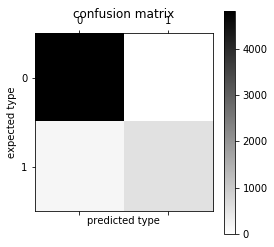

In [14]:
plt.matshow(confusion_matrix(messages['type'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected type')
plt.xlabel('predicted type')

In [15]:
print (classification_report(messages['type'], all_predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4825
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5572



# Creating a model with a Support Vector Machine

In [16]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['sms'], messages['type'], test_size=0.2)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [17]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# Pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # Pipeline from above
    param_grid=param_svm,  # Parameters to tune via cross validation
    refit=True,  # Fit using all data, on the best detected classifier
    n_jobs=-1,  # Number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # What type of cross validation to use
)

In [18]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # Find the best combination from param_svm
print (svm_detector.grid_scores_)

CPU times: user 4.04 s, sys: 148 ms, total: 4.19 s
Wall time: 1min 50s
[mean: 0.98676, std: 0.00372, params: {'classifier__C': 1, 'classifier__kernel': 'linear'}, mean: 0.98676, std: 0.00229, params: {'classifier__C': 10, 'classifier__kernel': 'linear'}, mean: 0.98676, std: 0.00229, params: {'classifier__C': 100, 'classifier__kernel': 'linear'}, mean: 0.98676, std: 0.00229, params: {'classifier__C': 1000, 'classifier__kernel': 'linear'}, mean: 0.87099, std: 0.00007, params: {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.87099, std: 0.00007, params: {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.87099, std: 0.00007, params: {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.87099, std: 0.00007, params: {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.97061, std: 0.00711, params: {'classifier__C': 100, 'classifier__gamma': 0.001, 'c

In [19]:
print (confusion_matrix(label_test, svm_detector.predict(msg_test)))
print (classification_report(label_test, svm_detector.predict(msg_test)))

[[942   1]
 [ 15 157]]
             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       943
       spam       0.99      0.91      0.95       172

avg / total       0.99      0.99      0.99      1115



In [26]:
pickle.dump(svm_detector, open('sms_spam_detector.pkl', 'wb'))

In [27]:
spam_detect = pickle.load(open('sms_spam_detector.pkl', 'rb'))